# 0.운영체제 과제 01
- 201901763 이지호

- 과제 1
- 마감 : 4월 30일(일) 저녁 6시까지
- 내용 :
    - 수업때 이야기한 모든 스케줄링 방법을 구현하고 성능(5가지) 비교
    - Json 파일로 입력정보를 주면 포맷을 체크해서 비교판단
    - 실시간스케줄링과 비실시간스케줄링을 Json  입력파일로 자동 구분처리
    - 파이썬만 사용, 간트차트 출력을 포함하여 5가지를 모두 비교하고, 각 입력 데이터에 대해 그 중 종합적으로 제일 나은 방법을 "자동" 결과 리포팅 (리포팅 내용을 간단한 설명을 포함하여 자동 생성)
    - 숫자 결과와 그래픽결과를 모두 나타내고 자동으로 리포팅
    - chatGPT 포함한 외부 자료 사용 절대 금함. 특성을 이미 잘 알고 있으므로,  사용흔적이 보이면 0점 처리

    - MarkDown 문서로 설명과 해설 그리고 주석이 포함된 주피터노트북 파일(*.ipynb 파일) 과 해당 파일을 PDF 로 저장한 파일, 입력에 사용하는 json 파일 3개 (입력예제 3개임) 등, 총 5개를 이러닝 사이트에 제출함.

    - 실행 결과는 절대 평가함. (제대로 되었는지 여부, 제출한 입력 포맷에 평가 데이터를 적용해서 진행)
    - 전체 결과는 등급제로 상대 평가함. 열심히 코드 만들고, 열심히 최선의 결과를 잘 만든 사람에게 높은 등급

    - 위 내용을 기준으로 추가로 필요한 부분은 스스로 판단해서 진행하면 됨. 의도에서 벗어나거나 축소되면 안됨.

# 1.분석 준비

## 1.1. Load data
- 아래 변수 숫자 (int) 변경해가며, (1), (2), (3)번 case 마다 실행 가능.

In [924]:
import copy
import matplotlib.pyplot as plt
import json

# _JSON_NUM_ 변경해가며 출력 가능
_JSON_NUM_ = 1
# 입력할 전체 프로세스들의 시간 길이. 스케쥴링 완료 시 이전에 for문 종료
_MAX_TIME_LENGTH_ = 999
# Round robin
_QUANTUM_TIME_ = 20
# print flag
_PRINT_FLAG_ = False

In [925]:
def data_loader():
    print("--Data_loader-----------------")
    _jsonfilename = "case" + str(_JSON_NUM_) + ".json"
    with open(_jsonfilename) as f:
        json_object = json.load(f)

    num_of_processs = len(json_object['list'])
    print("- Num of Process :", num_of_processs)

    # data checking
    assert json_object['list']
    for i in range(num_of_processs):
        assert json_object['list'][i]["Num"] > 0
        assert json_object['list'][i]["Burst_time"] > 0
        assert json_object['list'][i]["Priority"] > 0
        assert json_object['list'][i]["Arrival_time"] >= 0
    print("- Data Loading Success")

    return json_object

_DATA_ = data_loader()["list"]


--Data_loader-----------------
- Num of Process : 5
- Data Loading Success


## 1.2. Function
### 1.2.1. draw()


#### 1.2.1.1. Color List
- Process 마다 같은 색으로 시각화 하기 위해 색상표 작성.
- "_COLORS_" 변수 길이 이상의 Process 갯수가 입력 될 시, 랜덤 색상 배정.

In [926]:
file = open("color_list.txt", "r")
_COLORS_ = file.read().splitlines()
file.close()
print("_COLORS_ length is :", len(_COLORS_))

_COLORS_ length is : 117


#### 1.2.1.2. draw Gantt chart
- 프로세스 목록 json 파일 + Order 배열만으로 ploting 일반화 함.
    - ex...
    - Order == [[1, 50], [2, 30], [3, 40]]
    - 1번 프로세스 50, 이후 2번 프로세스 30, 이후 3번 프로세스 40.. 

In [927]:
_ALL_JOB_IS_DONE_ = -999
_NON_PROCESS_ = -1

def draw(_order):
    print("- Order is :", _order)
    if (_PRINT_FLAG_ == True):
        print("--Start Analysis--------------")
    fig, ax = plt.subplots(figsize=(10, 1))
    _process = copy.deepcopy(_DATA_)
    _sum_of_busrt_time = 0
    _sum_of_response_time = 0
    _sum_of_turnaround_time = 0
    _sum_of_running_time = 0
    _now_time = 0
    _cumsum_waiting_time = 0

    _xlim_tickers = []

    # 완전동작 카운터
    _start_counter = 0
    _done_counter = 0

    for _pid, _runtime in _order:
        # NOT CPU RUNNING
        if (_pid < 0):
            if (_runtime > 0):
                # TAKE A REST
                _now_time += _runtime
                continue
            elif (_runtime == _ALL_JOB_IS_DONE_):
                # ALL JOP IS DONE
                break
        # CPU RUNNING
        else:
            # P_num은 1부터 시작하기에, index 맞추는 용도.
            _JUST_PRINT_IDX_ = _pid
            for i in range(len(_process)):
                if (_process[i]['Num'] == _pid):
                    _target = _process[i]
            
            # First come in CPU
            if (_target['Priority'] > 0):
                _sum_of_response_time += _now_time
                if (_PRINT_FLAG_ == True):
                    print("START - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                # target의 우선순위에 음수로 시작시간 저장
                # order는 정해져있고, Priority는 이 단계에서 사용하지 않음.
                _target['Priority'] = 0
                _target['Priority'] = - _now_time
                _start_counter += 1
                _xlim_tickers.append(_now_time)
            
            _sum_of_busrt_time += _target['Burst_time']
            _cumsum_waiting_time += _now_time
            
            ax.barh(0, _runtime, left=_now_time,
                    edgecolor='black', color=_COLORS_[_JUST_PRINT_IDX_-1])
            _now_time += _runtime
            ax.text(_now_time - _runtime/2, 0,
                    ('P'+str(_JUST_PRINT_IDX_)), ha='center', va='center')
            _xlim_tickers.append(_now_time)
            
            # burst_time - running time
            _target['Burst_time'] -= _runtime
            
            # JOP IS DONE ?
            if (_target['Burst_time'] == 0):
                if (_PRINT_FLAG_ == True):
                    print(" P", _JUST_PRINT_IDX_, "Turnaround time is",_now_time - _target['Arrival_time'])
                _sum_of_turnaround_time += _now_time - _target['Arrival_time']
                if (_PRINT_FLAG_ == True):
                    print(" P", _JUST_PRINT_IDX_, "Running    time is", _now_time -abs(_target['Priority']))
                _sum_of_running_time += _now_time - abs(_target['Priority'])
                if (_PRINT_FLAG_ == True):
                    print("EXIT  - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                    print("")
                _done_counter +=1
                
    # ploting
    if (_PRINT_FLAG_ == True):
        print("------------------------------")
    ax.set_xticks(_xlim_tickers)
    ax.set_xlim([0, _now_time])
    ax.set_yticks([])
    if (_start_counter != len(_process)):
        print("응 오류야 ㅋㅋ~ 정상시작 횟수 :", _start_counter)
    else:
        print("ALL START GOOD JOB!!!")
    if (_done_counter != len(_process)):
        print("응 오류야 ㅋㅋ~ 정상종료 횟수 :", _done_counter)
    else:
        print("ALL EXIT  GOOD JOB!!!")
    plt.show()
    

    # print value
    if (_PRINT_FLAG_ == True):
        # cpu 이용률    
        print("CPU utilization : %2.2f" % float(_sum_of_busrt_time/_now_time*100), "%")
        # 단위 시간당 처리된 프로세스의 개수
        print("Throughput :", len(_process)/_now_time)
        # 프로세스를 cpu가 실행하지 않은 평균 대기시간
        print("Average waiting time :", _cumsum_waiting_time/len(_process))
        # 프로세스를 처음으로 실행하는 데에 걸린 시간
        print("Average Response time :", _sum_of_response_time/len(_process))
        # 시작하고 나서부터 완료까지 걸린 시간
        print("Average Running time :", _sum_of_running_time/len(_process))
        # 처음 대기 부터, 작업 완료에 대한 총 소요 시간 / p's 종료시점 - arrival_time
        print("Average Turnaround time :", _sum_of_turnaround_time/len(_process))

### 1.2.3. is_complete()
- 해당 list에 들은 burst time의 합이 0인지 판단하기


In [928]:
def is_complete(_list):
    # 해당 list에 들은 burst time의 합이 0인이 판단하기
    _sum_of_all_burst_time = 0
    for i in _list:
        _sum_of_all_burst_time += i['Burst_time']
    if (_sum_of_all_burst_time == 0):
        return True
    else:
        return False

### 1.2.3. order_zip()
- order 압축기

In [929]:
def order_zip(_order):
    # _order 압축기
    # [5, 1]. [5, 1],..을 [5, 2]로 압축해줌
    _idx = 0
    while (_idx < len(_order)):
        # 만약 종료 지점 만나면 무한루프 탈출
        if (_order[_idx] == [_NON_PROCESS_, _ALL_JOB_IS_DONE_]):
            break
        # 만약 같은 프로세스의 작업지시 만나면 합체
        elif (_order[_idx][0] == _order[_idx + 1][0]):
            _order[_idx + 1][1] += _order[_idx][1]
            _order.pop(_idx)
        # 다른 프로세스 만난거면 다음 process 압축하러 넘어감
        else:
            _idx += 1
    return _order


# 2.Scheduling Report


## 2.1. First-come, First-Served
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순

- Order is : [[1, 30], [2, 15], [5, 5], [-1, 35], [4, 50], [3, 25], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


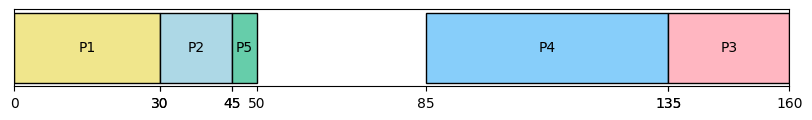

In [930]:
def FCFO():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1
                
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _order.append([_process['Num'], _process['Burst_time']])
                    _end_time += _process['Burst_time']
                    _process['Burst_time'] = 0
    _order = order_zip(_order)
    draw(_order)
    
FCFO()

## 2.2. Shortest-Job-First


### 2.2.1. SJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, Burst_time만 고려

- Order is : [[1, 30], [2, 15], [5, 5], [-1, 35], [4, 50], [3, 25], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


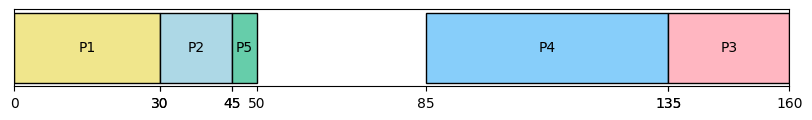

In [931]:
def SJF():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1
                
            # 현재 시간에 도착해있는 작업들 리스트업
            _queue = []
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)
            
            # 정렬 후 order에 추가    
            _queue.sort(key=lambda x: x['Burst_time'])
            for _process in _queue:
                _order.append([_process['Num'], _process['Burst_time']])
                _end_time += _process['Burst_time']
                _process['Burst_time'] = 0
    
    _order = order_zip(_order)
    draw(_order)

SJF()

### 2.2.2. Preemptive_SFJ
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, Burst_time만 고려
- 단, Burst_time 짧은 process 도착 시, 이것으로 대체 됨.

- Order is : [[1, 10], [2, 15], [5, 5], [1, 20], [-1, 35], [4, 50], [3, 25], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


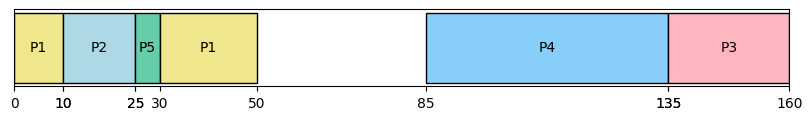

In [932]:
def Preemptive_SFJ():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):

        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    # _arrival_list.append(_process)
                    _queue.append(_process)
            
            # _now_time 마다 큐에서 스케쥴링
            # (1) 일단 앞에서부터 burst_time == 0 인 프로세스 있을 때 마다 다음 실행을 위해 인덱스 넘어감
            _idx = 0
            while (_queue[_idx]['Burst_time'] == 0):
                # index 넘어가는데, 도착 목록들에 남은 것 있으면 넘기기
                if (is_complete(_queue) == False):
                    _idx += 1
                # 미도착 목록 존재하면 idx넘어가지 않음. out of range error있음.
                else:
                    break
            
            # 원래의 burst_time 순으로 정렬하기
            _compare_queue = copy.deepcopy(_DATA_)
            _compare_queue = [tmp for tmp in _compare_queue if tmp['Num'] in [q['Num'] for q in _queue]]
            _compare_queue.sort(key=lambda x: x['Burst_time'])
            
            # (2) 원래 짧은 시간이 누구인가 찾았음. 그 프로세스는 _queue에서는 시간이 줄어든 채로 있을 것임.
            # 그 줄어든 burst_time을 가지는 친구를 _queue에서 찾아야함. >> _idx가 찾은 결과
            for i in range(len(_queue)):
                if (_compare_queue[0]['Num'] == _queue[i]['Num'] and _queue[i]['Burst_time'] != 0):
                    _idx = i
                    
            # (1)과 (2)에서 정해진 인덱스 둘 중 하나로 스케쥴링한다.
            _process = _queue[_idx]
            if (_process['Burst_time'] > 0):
                if (_process['Burst_time'] - 1 >= 0):
                    _order.append([_process['Num'], 1])
                    _end_time += 1
                    _process['Burst_time'] -= 1
            
    _order = order_zip(_order)
    draw(_order)

Preemptive_SFJ()


### 2.2.3. Preemptive_SRJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, 잔여 Burst_time 고려
- 단, 잔여 Burst_time 짧은 process 발견 시, 이것으로 대체 됨.

- Order is : [[1, 10], [2, 15], [5, 5], [1, 20], [-1, 35], [4, 5], [3, 25], [4, 45], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


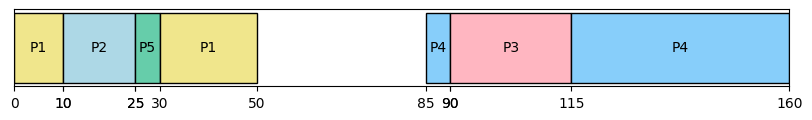

In [933]:
def Preemptive_SRJF():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _original_burst_time = copy.deepcopy(_DATA_)

    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):

        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    # _arrival_list.append(_process)
                    _queue.append(_process)
                    
            # 남은 burst_time 순으로 정렬하기
            _queue.sort(key=lambda x: x['Burst_time'])
            # _now_time 마다 큐에서 스케쥴링
            _idx = 0
            while (_queue[_idx]['Burst_time'] == 0):
                # index 넘어가는데, 도착 목록들에 남은 것 있으면 넘기기
                if (is_complete(_queue) == False):
                    _idx += 1
                # 미도착 목록 존재하면 idx넘어가지 않음. out of range error있음.
                else:
                    break

            _process = _queue[_idx]
            if (_process['Burst_time'] > 0):
                if (_process['Burst_time'] - 1 >= 0):
                    _order.append([_process['Num'], 1])
                    _end_time += 1
                    _process['Burst_time'] -= 1

    _order = order_zip(_order)
    draw(_order)


Preemptive_SRJF()

## 2.3. Priority First Served

### 2.3.1. Priority
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순

- Order is : [[1, 30], [2, 15], [5, 5], [-1, 35], [4, 50], [3, 25], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


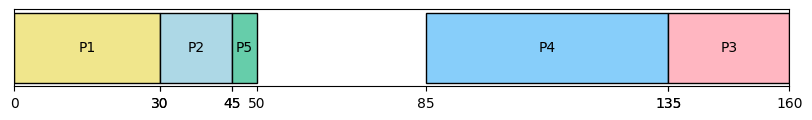

In [934]:
def Priority():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            _queue = []
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)

            # 정렬 후 order에 추가
            _queue.sort(key=lambda x: x['Priority'])
            for _process in _queue:
                _order.append([_process['Num'], _process['Burst_time']])
                _end_time += _process['Burst_time']
                _process['Burst_time'] = 0
    _order = order_zip(_order)
    draw(_order)

Priority()


### 2.3.2. Preemptive_Priority
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순
- 단, 더 높은 우선 순위 process 발견 시 이것으로 대체 됨.

- Order is : [[1, 10], [2, 15], [1, 20], [5, 5], [-1, 35], [4, 50], [3, 25], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


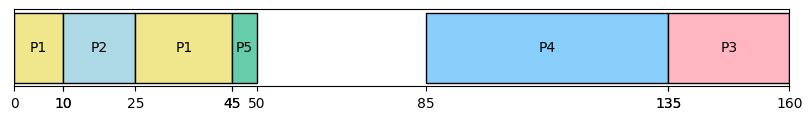

In [935]:
def Preemptive_Priority():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):

        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    # _arrival_list.append(_process)
                    _queue.append(_process)

            # 남은 Priority 순으로 정렬하기
            _queue.sort(
                key=lambda x: x['Priority'])

            # _now_time 마다 큐에서 스케쥴링
            _idx = 0
            while (_queue[_idx]['Burst_time'] == 0):
                # index 넘어가는데, 도착 목록들에 남은 것 있으면 넘기기
                if (is_complete(_queue) == False):
                    _idx += 1
                # 미도착 목록 존재하면 idx넘어가지 않음. out of range error있음.
                else:
                    break

            _process = _queue[_idx]
            if (_process['Burst_time'] > 0):
                if (_process['Burst_time'] - 1 >= 0):
                    _order.append([_process['Num'], 1])
                    _end_time += 1
                    _process['Burst_time'] -= 1
    _order = order_zip(_order)
    draw(_order)


Preemptive_Priority()

## 2.4. Round robin
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- QUANTUM_TIME 내에 처리하지 못 할 경우, 남은 Burst_time은 큐의 맨 뒤로 감.

### 2.4.1. Round Robin

- Order is : [[1, 30], [2, 15], [5, 5], [-1, 50], [3, 20], [4, 20], [3, 5], [4, 30], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


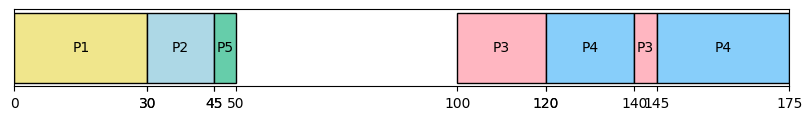

In [936]:
def RR():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1
                
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    # _arrival_list.append(_process)
                    _queue.append(_process)
            
            # _QUANTUM_TIME_ 마다 큐에서 스케쥴링
            if (_now_time % _QUANTUM_TIME_ == 0):
                _queue.sort(key=lambda x: x['Num'])
                for _process in _queue:
                    if (_process['Burst_time'] > 0):
                        if (_process['Burst_time'] > _QUANTUM_TIME_):
                            _order.append([_process['Num'], _QUANTUM_TIME_])
                            _end_time += _QUANTUM_TIME_
                            _process['Burst_time'] -= _QUANTUM_TIME_
                        else:
                            _order.append([_process['Num'], _process['Burst_time']])
                            _end_time += _process['Burst_time']
                            _process['Burst_time'] = 0

    _order = order_zip(_order)
    draw(_order)

RR()

### 2.4.2. Priority + Round robin
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- QUANTUM_TIME 내에 처리하지 못 할 경우, 남은 Burst_time은 큐의 맨 뒤로 감.
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순

- Order is : [[1, 20], [2, 15], [1, 10], [5, 5], [-1, 50], [4, 20], [3, 20], [4, 20], [3, 5], [4, 10], [-1, -999]]
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


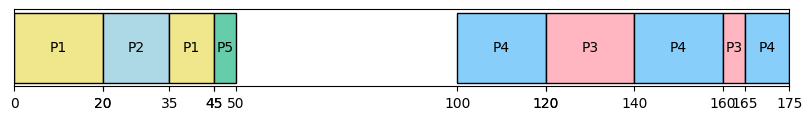

In [937]:
def Priority_RR():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):

        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    # _arrival_list.append(_process)
                    _queue.append(_process)

            # _QUANTUM_TIME_ 마다 큐에서 스케쥴링
            if (_now_time % _QUANTUM_TIME_ == 0):
                _queue.sort(key=lambda x: x['Priority'])
                for _process in _queue:
                    if (_process['Burst_time'] > 0):
                        if (_process['Burst_time'] > _QUANTUM_TIME_):
                            _order.append([_process['Num'], _QUANTUM_TIME_])
                            _end_time += _QUANTUM_TIME_
                            _process['Burst_time'] -= _QUANTUM_TIME_
                        else:
                            _order.append(
                                [_process['Num'], _process['Burst_time']])
                            _end_time += _process['Burst_time']
                            _process['Burst_time'] = 0
    
    _order = order_zip(_order)
    draw(_order)


Priority_RR()

## 2.5. Multi Level Queue

### 2.5.1. Multi Level Queue


- Order is : []
응 오류야 ㅋㅋ~ 정상시작 횟수 : 0
응 오류야 ㅋㅋ~ 정상종료 횟수 : 0


/var/folders/5c/wv993t2x5_j6ck444smxp6t00000gn/T/ipykernel_9097/936478746.py:83: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([0, _now_time])


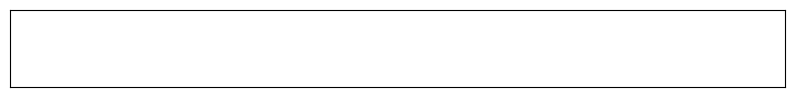

In [938]:
def Multilevel_queue():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    _order = order_zip(_order)
    draw(_order)


Multilevel_queue()


### 2.5.2. Multi Level Feedback Queue

- Order is : []
응 오류야 ㅋㅋ~ 정상시작 횟수 : 0
응 오류야 ㅋㅋ~ 정상종료 횟수 : 0


/var/folders/5c/wv993t2x5_j6ck444smxp6t00000gn/T/ipykernel_9097/936478746.py:83: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([0, _now_time])


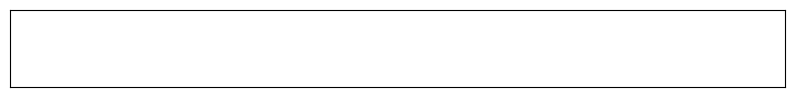

In [939]:
def Multilevel_feedback_queue():
    _order = []
    _list = copy.deepcopy(_DATA_)
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    
    
    
    
    _order = order_zip(_order)
    draw(_order)


Multilevel_feedback_queue()
